In [7]:
using LinearAlgebra
using Random
using Distributions
using KernelDensity
include("../Inversion/Plot.jl")
include("../Inversion/GMBBVI.jl")
include("../Inversion/AnnealingInitialize.jl")
include("./MultiModal.jl")
Random.seed!(123);


In [8]:
function visualization(ax, objs; Nx = 200, Ny = 200, x_lim = [-3.0, 3.0], y_lim = [-3.0, 3.0], N_iter = 200)
    
    x_min, x_max = x_lim 
    y_min, y_max = y_lim

    xx = LinRange(x_min, x_max, Nx)

    yy = LinRange(y_min, y_max, Ny)
    dx, dy = xx[2] - xx[1], yy[2] - yy[1]
    X,Y = repeat(xx, 1, Ny), repeat(yy, 1, Nx)'

    Z_ref = (func_Phi === nothing ? posterior_2d(func_F, X, Y, "func_F") : posterior_2d(func_Phi, X, Y, "func_Phi"))
    color_lim = (minimum(Z_ref), maximum(Z_ref))
    ax[1].pcolormesh(X, Y, Z_ref, cmap="viridis", clim=color_lim)

    N_obj = length(objs)
    errors = zeros(N_obj, N_iter+1)

    for (i,obj) in enumerate(objs)
        for iter = 0:N_iter
            x_w = exp.(obj.logx_w[iter+1]); x_w /= sum(x_w)
            x_mean = obj.x_mean[iter+1][:,1:2]
            xx_cov = obj.xx_cov[iter+1][:,1:2,1:2]
            Z = Gaussian_mixture_2d(x_w, x_mean, xx_cov,  X, Y)
            errors[i, iter+1] = norm(Z - Z_ref,1)*dx*dy
            if i == 1 && iter == N_iter  
                # plot the outcome of the first trial 
                ax[2].pcolormesh(X, Y, Z, cmap="viridis", clim=color_lim)
                ax[2].scatter([obj.x_mean[1][:,1];], [obj.x_mean[1][:,2];], marker="x", color="grey", alpha=0.5) 
                ax[2].scatter([x_mean[:,1];], [x_mean[:,2];], marker="o", color="red", facecolors="none", alpha=0.5)

                ax[2].set_xlim(x_lim)
                ax[2].set_ylim(y_lim)
            end
        end
    end

    error_mean = vec(mean(errors, dims=1))
    error_std = vec(std(errors, dims=1))

    ax[3].semilogy(Array(0:N_iter), error_mean, color = "red")
    ax[3].fill_between(Array(0:N_iter), error_mean - error_std, error_mean + error_std, color="blue", alpha=0.3)
end




visualization (generic function with 1 method)

[ Info: ("iter = ", 50, " / ", 500)
[ Info: ("iter = ", 100, " / ", 500)
[ Info: ("iter = ", 150, " / ", 500)
[ Info: ("iter = ", 200, " / ", 500)
[ Info: ("iter = ", 250, " / ", 500)
[ Info: ("iter = ", 300, " / ", 500)
[ Info: ("iter = ", 350, " / ", 500)
[ Info: ("iter = ", 400, " / ", 500)
[ Info: ("iter = ", 450, " / ", 500)
[ Info: ("iter = ", 500, " / ", 500)
[ Info: ("iter = ", 50, " / ", 500)
[ Info: ("iter = ", 100, " / ", 500)
[ Info: ("iter = ", 150, " / ", 500)
[ Info: ("iter = ", 200, " / ", 500)
[ Info: ("iter = ", 250, " / ", 500)
[ Info: ("iter = ", 300, " / ", 500)
[ Info: ("iter = ", 350, " / ", 500)
[ Info: ("iter = ", 400, " / ", 500)
[ Info: ("iter = ", 450, " / ", 500)
[ Info: ("iter = ", 500, " / ", 500)
[ Info: ("iter = ", 50, " / ", 500)
[ Info: ("iter = ", 100, " / ", 500)
[ Info: ("iter = ", 150, " / ", 500)
[ Info: ("iter = ", 200, " / ", 500)
[ Info: ("iter = ", 250, " / ", 500)
[ Info: ("iter = ", 300, " / ", 500)
[ Info: ("iter = ", 350, " / ", 500)
[ In

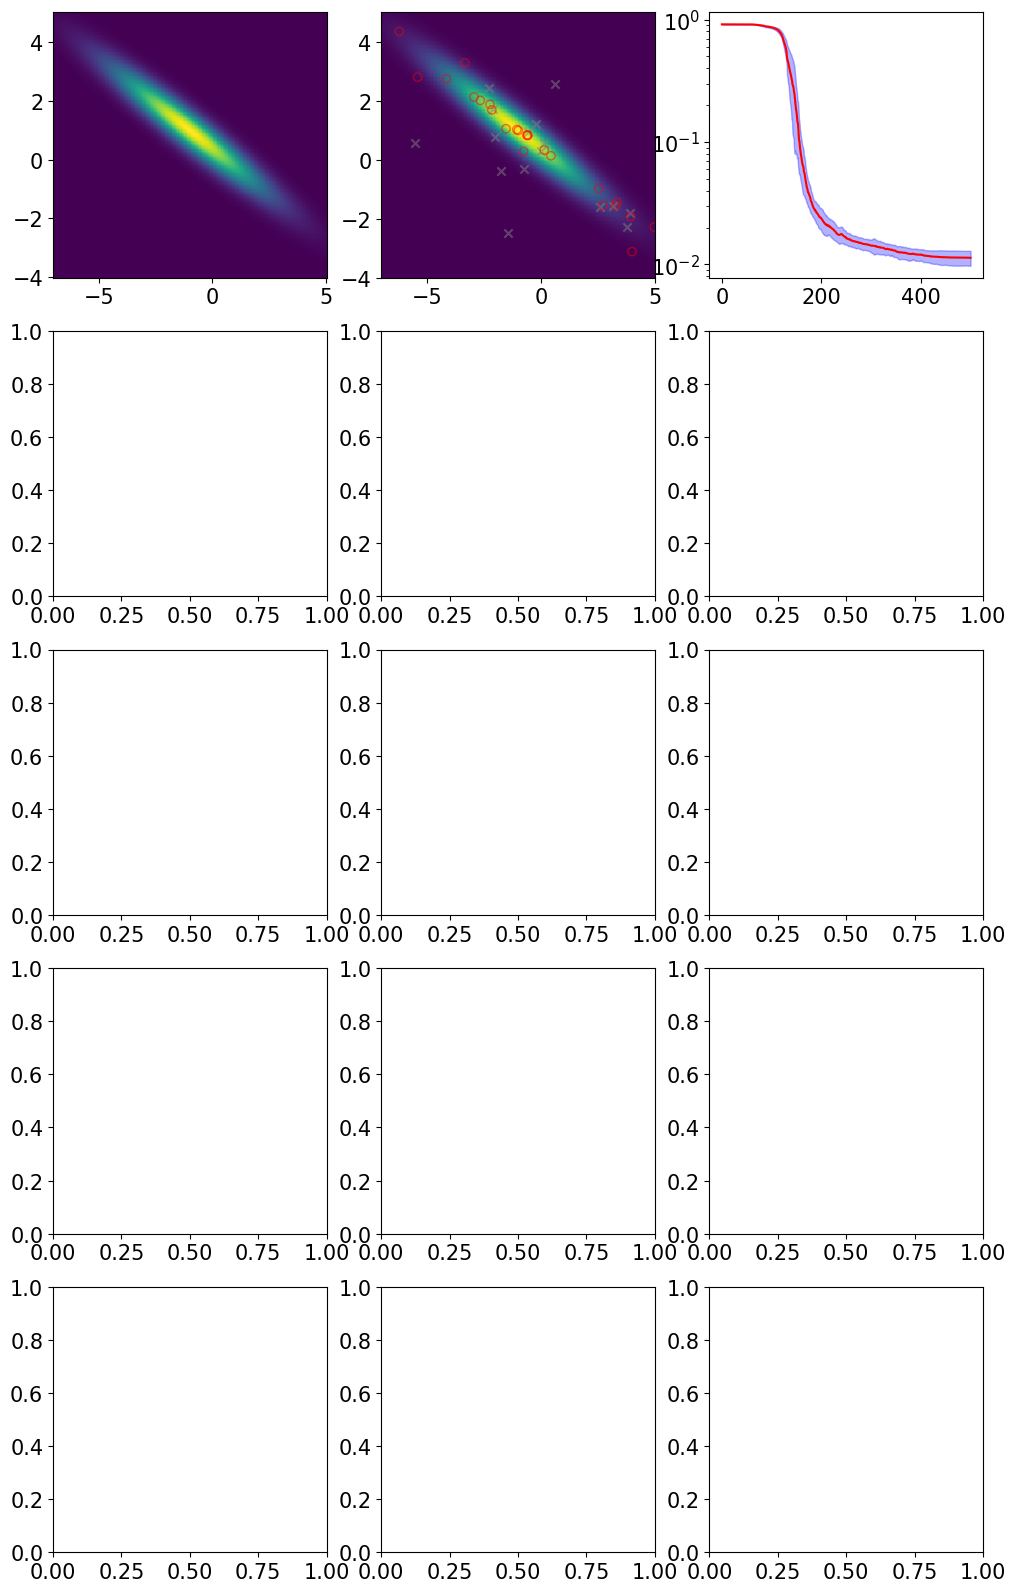

In [9]:
N_modes = 40 # number of modes in Gaussian mixture
N_ens= 1000 # number of paticles in MCMC
N_bbvi_sample = 5 # number of samples to compute expectation using Monte Carlo in GMBBVI

fig, ax = PyPlot.subplots(nrows=5, ncols=3, sharex=false, sharey=false, figsize=(12,20))


Random.seed!(111);
x0_w  = ones(N_modes)/N_modes
μ0, Σ0 = [0.0; 0.0], [1.0 0.0; 0.0 1.0]
N_x = length(μ0)
x0_mean, xx0_cov = zeros(N_modes, N_x), zeros(N_modes, N_x, N_x)
for im = 1:N_modes
    x0_mean[im, :]    .= rand(MvNormal(zeros(N_x), Σ0)) + μ0
    xx0_cov[im, :, :] .= Σ0
end
Hessian_correct_GM = false
ens_0=zeros(N_x,N_ens)
for j = 1:N_ens
    ens_0[:,j]  = rand(MvNormal(zeros(N_x), Σ0)) + μ0
end

N_iter = 500
Nx, Ny = 100,100
N_trials = 5 




ση = 1.0
Gtype = "Gaussian"
dt = 0.5
A = [1.0 1.0; 1.0 2.0]
y = [0.0; 1.0; zeros(N_x-2)]
func_args = (y, ση, A , Gtype)
func_F(x) = F(x, func_args)
func_dPhi(x) = dPhi(x, func_args)
func_prob(x) = exp(logrho(x, func_args))
func_Phi(x)= -logrho(x, func_args)


x0_w_anneal, x0_mean_anneal, xx0_cov_anneal = initialize_with_annealing(func_Phi, x0_w, x0_mean, xx0_cov)
objs = []
for _ = 1:N_trials
    obj = Gaussian_mixture_GMBBVI(func_Phi, x0_w_anneal, x0_mean_anneal, xx0_cov_anneal; N_iter = N_iter, dt = dt, N_ens=N_bbvi_sample)
    push!(objs, obj)
end  
visualization(ax[1,:], objs; Nx = 200, Ny = 200, x_lim = [-7.0, 5.0], y_lim = [-4.0, 5.0], N_iter = N_iter)



# ση = 1.0
# Gtype = "Four_modes"
# y = [4.2297; 4.2297; 0.5; 0.0; zeros(N_x-2)]
# func_args = (y, ση, 0, Gtype)
# func_F(x) = F(x, func_args)
# func_dPhi(x) = dPhi(x, func_args)
# func_prob(x)=exp(logrho(x, func_args))
# func_Phi(x)= -logrho(x, func_args)

# x0_w_anneal, x0_mean_anneal, xx0_cov_anneal = initialize_with_annealing(func_Phi, x0_w, x0_mean, xx0_cov)
# objs = []
# for _ = 1:N_trials
#     obj = Gaussian_mixture_GMBBVI(func_Phi, x0_w_anneal, x0_mean_anneal, xx0_cov_anneal; N_iter = N_iter, dt = dt, N_ens=N_bbvi_sample)
#     push!(objs, obj)
# end  
# visualization(ax[2,:], objs; Nx = 200, Ny = 200, x_lim = [-4.0, 4.0], y_lim = [-4.0, 4.0], N_iter = N_iter)



# ση = [0.3; ones(N_x-2)]
# Gtype = "Circle"
# A = [1.0 0.0; 0.0 1.0]
# y = [1.0; zeros(N_x-2)]
# func_args = (y, ση, A , Gtype)
# func_F(x) = F(x, func_args)
# func_dPhi(x) = dPhi(x, func_args)
# func_prob(x)=exp(logrho(x, func_args))
# func_Phi(x)= -logrho(x, func_args)

# x0_w_anneal, x0_mean_anneal, xx0_cov_anneal = initialize_with_annealing(func_Phi, x0_w, x0_mean, xx0_cov)
# objs = []
# for _ = 1:N_trials
#     obj = Gaussian_mixture_GMBBVI(func_Phi, x0_w_anneal, x0_mean_anneal, xx0_cov_anneal; N_iter = N_iter, dt = dt, N_ens=N_bbvi_sample)
#     push!(objs, obj)
# end   
# visualization(ax[3,:], objs; Nx = 200, Ny = 200, x_lim = [-3.0, 3.0], y_lim = [-3.0, 3.0], N_iter = N_iter)



# ση = [sqrt(10.0); sqrt(10.0); ones(N_x-2)]
# Gtype = "Banana"
# λ = 10.0
# y = [0.0; 1.0; zeros(N_x-2)]
# func_args = (y, ση, λ , Gtype)
# func_F(x) = F(x, func_args)
# func_dPhi(x) = dPhi(x, func_args)
# func_prob(x)=exp(logrho(x, func_args))
# func_Phi(x)= -logrho(x, func_args)

# x0_w_anneal, x0_mean_anneal, xx0_cov_anneal = initialize_with_annealing(func_Phi, x0_w, x0_mean, xx0_cov)
# objs = []
# for _ = 1:N_trials
#     obj = Gaussian_mixture_GMBBVI(func_Phi, x0_w_anneal, x0_mean_anneal, xx0_cov_anneal; N_iter = N_iter, dt = dt, N_ens=N_bbvi_sample)
#     push!(objs, obj)
# end   
# visualization(ax[4,:], objs; Nx = 200, Ny = 200, x_lim =  x_lim=[-4.0, 4.0], y_lim=[-2.0, 15.0], N_iter = N_iter)



# ση = [0.3; 1.0; 1.0; ones(N_x-2)]
# Gtype = "Double_banana"
# dt = 0.5
# λ = 100.0
# y = [log(λ+1); 0.0; 0.0; zeros(N_x-2)]
# func_args = (y, ση, λ , Gtype)
# func_F(x) = F(x, func_args)
# func_dPhi(x) = dPhi(x, func_args)
# func_prob(x) = exp(logrho(x, func_args))
# func_Phi(x) = -logrho(x, func_args)

# x0_w_anneal, x0_mean_anneal, xx0_cov_anneal = initialize_with_annealing(func_Phi, x0_w, x0_mean, xx0_cov)
# objs = []
# for _ = 1:N_trials
#     obj = Gaussian_mixture_GMBBVI(func_Phi, x0_w_anneal, x0_mean_anneal, xx0_cov_anneal; N_iter = N_iter, dt = dt, N_ens=N_bbvi_sample)
#     push!(objs, obj)
# end  
# visualization(ax[5,:], objs; Nx = 200, Ny = 200, x_lim = [-3.0, 3.0], y_lim = [-3.0, 3.0], N_iter = N_iter)


fig.savefig("GMBBVI-trials.pdf")


